# Exploratory Data Analysis (EDA)

In [107]:
# Import necessary libraries

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, fbeta_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os, cv2
from PIL import Image
import opendatasets as od
import zipfile

# Ignore warnings
import warnings
warnings.simplefilter("ignore")

In [51]:
# Download Dataset from WWW.kaggle.com

#od.download("https://www.kaggle.com/c/cassava-leaf-disease-classification/data?select=train.csv")

In [108]:
# Unzip zipped files and extract them to a directory

# with zipfile.ZipFile("/Users/paulosgidyelew/Downloads/cassava-disease/train.zip", 'r') as zip_file:
#     zip_file.extractall("data")

In [5]:
# Read csv file from directory and display head of dataset

df = pd.read_csv('data/train.csv')
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [6]:
# Overview of dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


Our dataset contains 21,397 observations

In [12]:
# Display category labels

df.label.unique()

array([0, 3, 1, 2, 4])

Our dataset is labeled and contains 5 different categories

In [13]:
# Organize data distribution in data frame

def data_dist(num):
    cbb,cbsd,cgm,cmd,healthy= [],[],[],[],[]
    count = 0
    for i in range(num):
        if i == 0:
            cbb.append(df.label[df.label==i].count())
        elif i == 1:
            cbsd.append(df.label[df.label==i].count())
        elif i == 2:
            cgm.append(df.label[df.label==i].count())
        elif i == 3:
            cmd.append(df.label[df.label==i].count())
        elif i == 4:
            healthy.append(df.label[df.label==i].count())
        else:
            total.append(df.label[df.label==i].count())
        count += df.label[df.label==i].count()
    #count = len(df.label)
    count = pd.DataFrame({'cbb':cbb,'cbsd':cbsd,'cgm':cgm,'cmd':cmd,'healthy':healthy,'total':count},index=['Count'])
    return count
    
# instantiation of function call

data_dist(len(df.label.unique()))


,cbb,cbsd,cgm,cmd,healthy,total
Count,1087,2189,2386,13158,2577,21397


# Laplacian Transformation:

Our dataset contains partly poor quality images. We need to find a solution to filter out these images from our dataset, since they will negatively impact the accuracy of our model. The laplace transform function is used to resolve this problem. In the following we will try to explain how this function would be applied and how it works.

Laplace filtering method used to identify and highlight fine edges based on the 2nd derivative.

`OpenCV.Laplacian(gray_img, ksize, scale)` returns filtered image

Parameters:

gray_img - Grayscale image data
ksize - apertures size used to calculate 2nd derivative filter, specifies the size of the kernel (must be an odd integer: 1,3,5...)
scale - scaling factor applied (multiplied) to computed Laplacian values (scale = 1 is unscaled)

Context:

It is used to define edges around objects. The function calculates the Laplacian of the source image by adding up the second x and y derivatives calculated using the Sobel operator:

$Laplace(f) = \dfrac{\partial^{2} f}{\partial x^{2}} + \dfrac{\partial^{2} f}{\partial y^{2}}$

When ksize = 1, the Laplacian is computed by filtering the image with the following 3×3 aperture:

$\begin{bmatrix}
0 & 1 & 0\\
1 & -4 & 1\\
0 & 1 & 0 
\end{bmatrix}$


<p style="text-align: justify">Function described in this section is used to perform linear or non-linear filtering operations on 2D images. It means that for each pixel location (x, y) in the source image (normally, rectangular), its neighborhood is considered and used to compute the response. In case of a linear filter, it is a weighted sum of pixel values. In case of morphological operations, it is the minimum or maximum values, and so on. The computed response is stored in the destination image at the same location (x, y). It means that the output image will be of the same size as the input image. Normally, the functions support multi-channel arrays, in which case every channel is processed independently. Therefore, the output image will also have the same number of channels as the input one.</p>

Depth combinations:

|Input depth (src.depth())	|Output depth (ddepth)|
|---|---|
|CV_8U	|-1/CV_16S/CV_32F/CV_64F|
|CV_16U/CV_16S	|-1/CV_32F/CV_64F|
|CV_32F	|-1/CV_32F/CV_64F|
|CV_64F	|-1/CV_64F|

<p style="text-align: justify">OpenCV BGR images or Gray_scale have pixel values from 0 to 255 when in CV_8U - corresponds to np.uint8. When we use the Laplacian transform with ddepth (desired depth of the destination image), we set it to OpenCV.CV_32F or OpenCV.CV_64F.</p> 

For more details [click here](https://docs.opencv.org/4.1.0/d4/d86/group__imgproc__filter.html#filter_depths)

In [14]:
# Import library 
import glob
# Laplace transform function

def laplacian(threshold, path):
    bad_img,lap_val = [],[]
    for img in glob.glob(path):
        image = cv2.imread(img)
        img_gry = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
        lap_var = cv2.Laplacian(img_gry,cv2.CV_32F,ksize=1).var()
        if lap_var < threshold:
            bad_img.append(img)
            lap_val.append(lap_var)
    bad_img_dict = {img:val for img,val in zip(bad_img,lap_val)}
    return bad_img_dict


In [54]:
# Instanciasion of function and variable assignment

bad_img_dict = laplacian(30, "data/test/0/*.jpg")

In [55]:
# Create a data frame for bad images

bad_img_lap = [i.split('/')[3] for i in bad_img_dict.keys()]
lap_val = bad_img_dict.values()
bad_img_S = pd.Series(bad_img_lap)
lap_var_S = pd.Series(lap_val)

bad_img_frm = pd.concat([bad_img_S,lap_var_S],axis=1)
bad_img_frm.columns = ['image_id','laplacian_var']
bad_img_frm.head()

,image_id,laplacian_var
0,test-img-3466.jpg,23.441036
1,test-img-3098.jpg,29.456614
2,test-img-721.jpg,13.840843
3,test-img-590.jpg,25.694542
4,test-img-405.jpg,16.480913


With this function we can filter out blurred imaged. Comparing size of data that we have on hand the amount of bad images is insignificant. By decreasing the threshold we can filter images with sever blurriness.

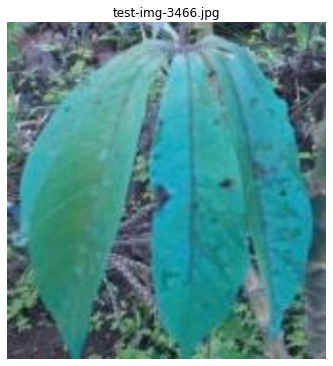

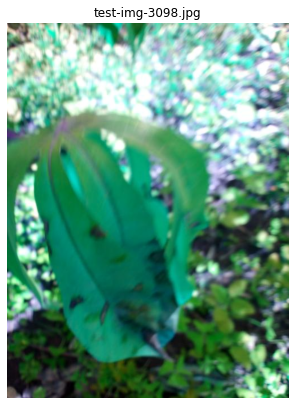

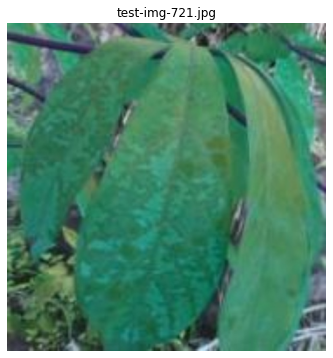

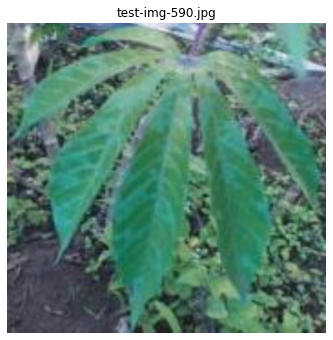

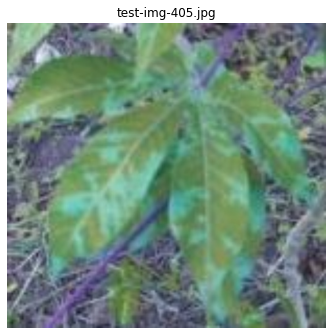

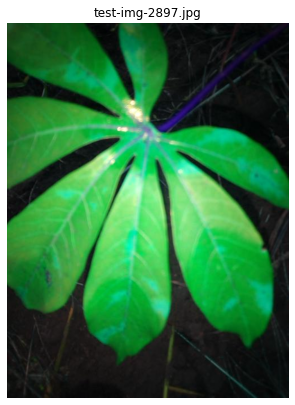

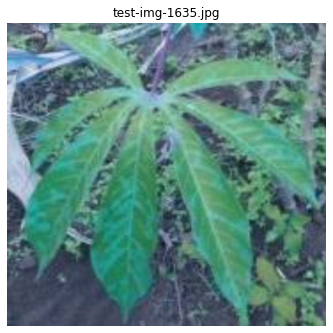

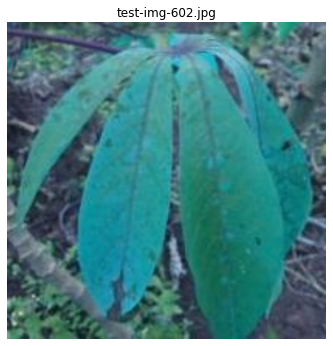

In [56]:
# bad_image plot function

def bad_img_plot(data,rows):
    for idx, img in enumerate(data):
        image = cv2.imread(img)
        fig = plt.figure(figsize=(40,40))
        fig.add_subplot(rows,6,idx+1)
        plt.title(img.split('/')[3])
        plt.axis('off')
        plt.imshow(image)
    return plt.show()

# instanciasion of function
bad_img_plot(bad_img_dict.keys(),5)

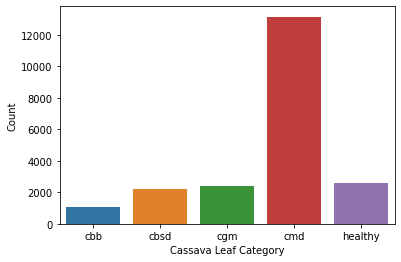

In [ ]:
# Plot data distribution

sns.countplot(data = df, x=df.label)
plt.xlabel('Cassava Leaf Category')
plt.ylabel('Count')
plt.xticks([0,1,2,3,4],['cbb','cbsd','cgm','cmd','healthy'])
plt.show()

The plot above clearly shows that our data distribution is imbalanced

In [106]:
# baseline model prediction

y_pred = np.dot(np.ones(len(df.label)),3)
score = accuracy_score(y_pred, df.label)
beta_score_precision = fbeta_score(df.label, y_pred, average='weighted', beta=0.5)
beta_score_recall = fbeta_score(df.label, y_pred, average='weighted', beta=2)
print(f'baseline accuracy : {score.round(2)}')
print(f'F_beta_score_precision: {beta_score_precision.round(2)}')
print(f'F_beta_score_recall: {beta_score_recall.round(2)}')

baseline accuracy : 0.61
F_beta_score_precision: 0.41
F_beta_score_recall: 0.55


<p style="text-align:justify"><span style="color:green">From our dataset the probability of getting CMD is <b>61.5%</b>,that of CBB <b>5.1%</b>, CBSD <b>10.2%</b>, CGM <b>11.2%</b> and a Healthy one<b>12.0%</b>. Our baseline model is a probability function where its prediction is based on a label with the highest probability rate which is CMD(3). However, due to the imbalanced nature of our dataset accuracy can be a misleading metric in our model prediction.</span></p>  

In the above $F_{\beta}$ score we assigned the "average" parameter as "weighted" since our dataset is not balanced. See below for the explanation of the values of the parameter:

<b>'micro':</b>
Calculate metrics globally by counting the total true positives, false negatives and false positives.

<b>'macro':</b>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

<b>'weighted':</b>
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.